# Data Processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,  GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, silhouette_score, plot_confusion_matrix, plot_roc_curve, make_scorer, recall_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn. discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from factor_analyzer import FactorAnalyzer
import seaborn as sbn
from pipeline_utils import ColumnRemover
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('high_diamond_ranked_10min.csv')
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
data['blueWins'].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

## Removing Duplicate Rows and Columns

In [4]:
to_drop = ['gameId','blueGoldDiff','blueExperienceDiff','redFirstBlood','redGoldDiff','redExperienceDiff']
data = data.drop(to_drop, axis = 1)

data = data.drop_duplicates()

print(data.shape)
print(data.T.duplicated())
data = data.loc[:,~data.T.duplicated()]
print(data.shape)

(9879, 34)
blueWins                        False
blueWardsPlaced                 False
blueWardsDestroyed              False
blueFirstBlood                  False
blueKills                       False
blueDeaths                      False
blueAssists                     False
blueEliteMonsters               False
blueDragons                     False
blueHeralds                     False
blueTowersDestroyed             False
blueTotalGold                   False
blueAvgLevel                    False
blueTotalExperience             False
blueTotalMinionsKilled          False
blueTotalJungleMinionsKilled    False
blueCSPerMin                    False
blueGoldPerMin                  False
redWardsPlaced                  False
redWardsDestroyed               False
redKills                         True
redDeaths                        True
redAssists                      False
redEliteMonsters                False
redDragons                      False
redHeralds                      False
r

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9879 entries, 0 to 9878
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   float64
 13  blu

## Setting columns to categorical or numeric

In [6]:
cat_cols = ['blueFirstBlood']
num_cols = []
for col in data:
    if col not in cat_cols:
        num_cols.append(col)
num_cols.remove('blueWins')

## Removing Linearly Dependent Attributes

In [7]:
Q,R = np.linalg.qr(data[num_cols])
dep_cols=[]
for i in range(0, len(R)):
    if abs(R[i,i]) < 1e-10:
        dep_cols.append(num_cols[i])

print('Columns: ' + str(data.select_dtypes(include=np.number).columns))
print('Dependent Columns: ' + str(dep_cols))

pd.DataFrame(R)

num_cols = [col for col in num_cols if col not in dep_cols]

data = data.drop(dep_cols, axis=1)

Columns: Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueCSPerMin', 'blueGoldPerMin',
       'redWardsPlaced', 'redWardsDestroyed', 'redAssists', 'redEliteMonsters',
       'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold',
       'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')
Dependent Columns: ['blueHeralds', 'blueCSPerMin', 'blueGoldPerMin', 'redHeralds', 'redCSPerMin', 'redGoldPerMin']


## Plotting Boxplots

In [8]:
#for col in num_cols:
#    fig = sbn.boxplot(data = data, x='blueWins', y=col, palette=['red','blue'])
#    fig.set_xticklabels(labels=['Red Wins','Blue Wins'])
#    plt.title('Boxplot of '+str(col))
#    plt.xlabel('Game Outcome')
#    plt.savefig('exploratory_plots/'+str(col)+'_fig')
#    plt.clf()

## Performing PCA

In [9]:
scl_data = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]))
scl_data.to_csv('R_Cross_Val/cross_val_with_R.csv')

In [10]:
dpca = PCA().fit(scl_data)

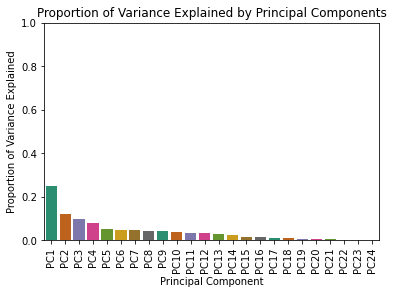

In [11]:
pcs = ['PC'+str(i) for i in range(1, dpca.n_features_+1)]

bplot = sbn.barplot(x = pcs, y = dpca.explained_variance_ratio_, palette='Dark2')
bplot.set_xticklabels(labels = pcs,rotation=90)
plt.ylim(0,1)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Proportion of Variance Explained by Principal Components')
plt.show()

In [12]:
pd.DataFrame({
    'Principal Components' : pcs, 
    'Explained Variance' : dpca.explained_variance_ratio_
    })

,Principal Components,Explained Variance
0,PC1,0.250495
1,PC2,0.119648
2,PC3,0.099237
3,PC4,0.079012
4,PC5,0.051820
5,PC6,0.045713
6,PC7,0.044599
7,PC8,0.044221
8,PC9,0.040193
9,PC10,0.038160


All components from the 23rd onwards explain less than 1% of the sample variance. Removing components \[17, 24].

In [13]:
tmp = {}
for i, ele in enumerate(num_cols):
    tmp[i] = ele
pd.DataFrame(dpca.components_.T[:,0:4]).rename(index=tmp)

,0,1,2,3
blueWardsPlaced,-0.011605,0.009783,-0.014804,-0.030626
blueWardsDestroyed,-0.039683,-0.028902,-0.004526,-0.017346
blueKills,-0.259357,0.348955,0.135478,-0.204225
blueDeaths,0.251291,0.376661,-0.038373,-0.210543
blueAssists,-0.218912,0.332907,0.107156,-0.159091
blueEliteMonsters,-0.186630,0.005373,-0.420465,-0.083857
blueDragons,-0.177220,0.019580,-0.484923,-0.059978
blueTowersDestroyed,-0.110086,0.085577,0.074563,-0.028076
blueTotalGold,-0.315703,0.218102,0.164458,-0.272306
blueAvgLevel,-0.280520,-0.148631,0.124230,-0.363870


Loadings for the first 4 principal components.

In [14]:
dpca.explained_variance_

array([6.0124963 , 2.87183966, 2.38193378, 1.89649088, 1.24381387,
       1.09721643, 1.07047859, 1.06141602, 0.96473676, 0.91592924,
       0.79382183, 0.77442106, 0.71283837, 0.60433503, 0.38556877,
       0.30160946, 0.23637245, 0.18984382, 0.14347751, 0.12949052,
       0.07799575, 0.06955545, 0.03569547, 0.03105261])

Eigenvalues (variances) for each principal component.

## Splitting Training and Test

In [15]:
train_data, test_data = train_test_split(data, stratify = data['blueWins'], test_size = 0.2, random_state=43)

In [16]:
train_data['blueWins'].value_counts()

0    3959
1    3944
Name: blueWins, dtype: int64

## Preprocessing

In [17]:
numerical_transform = Pipeline(steps=[
    ('Scaler', StandardScaler()),
    ('PCA', PCA()),
    ('Component Remover', ColumnRemover(rm_cols=[i for i in range(16,24)]))
])

preprocessor = ColumnTransformer(transformers = [
    ('Numeric Transforms', numerical_transform, num_cols)
], remainder = 'passthrough', n_jobs=-1)

In [18]:
y_train = train_data['blueWins']
x_train = train_data.drop('blueWins', axis=1)

y_test = test_data['blueWins']
x_test = test_data.drop('blueWins', axis=1)

## Performing Cluster Analysis

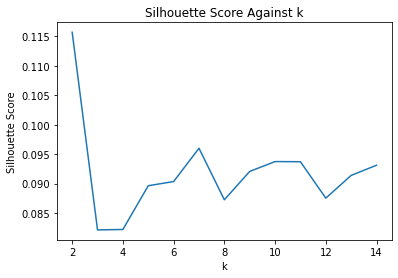

In [19]:
x_tmp = preprocessor.fit_transform(x_train)

sil = []
ks = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k,random_state=67).fit(x_tmp)
    sil.append(silhouette_score(x_tmp,kmeans.labels_,metric='manhattan'))
    ks.append(k)
plt.plot(ks,sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Against k')
plt.show()

Silhouette scores indicate poor clustering. Thus, clustering will be removed from the model.

# Building Models

In [20]:
cv = KFold(n_splits=3, random_state=758, shuffle=True)
macro_recall = make_scorer(recall_score, average='macro')

In [21]:
train_data, test_data = train_test_split(data, stratify = data['blueWins'], test_size = 0.6, random_state=43)

y_train = train_data['blueWins']
x_train = train_data.drop('blueWins', axis=1)

y_test = test_data['blueWins']
x_test = test_data.drop('blueWins', axis=1)

## Linear Discriminant Analysis

In [22]:
#Optimising model in region about default values
params = {
    'LDA__solver' : ['svd', 'lsqr', 'eigen']
}

lda = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('LDA', LinearDiscriminantAnalysis())
])

gd_sr = GridSearchCV(estimator=lda,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose = 10)
gd_sr.fit(x_train,y_train)
lda = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    1.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    1.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    1.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.5s finished
Optimal Paramaters: {'LDA__solver': 'svd'}


In [23]:
print('\n')
print('Linear Discriminant Classifier Train Data Report')
print(classification_report(y_pred = lda.predict(x_train), y_true = y_train))

print('\n')
print('Linear Discriminant Classifier Test Data Report')
print(classification_report(y_pred = lda.predict(x_test), y_true = y_test))



Linear Discriminant Classifier Train Data Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1979
           1       0.73      0.74      0.73      1972

    accuracy                           0.73      3951
   macro avg       0.73      0.73      0.73      3951
weighted avg       0.73      0.73      0.73      3951



Linear Discriminant Classifier Test Data Report
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      2970
           1       0.72      0.72      0.72      2958

    accuracy                           0.72      5928
   macro avg       0.72      0.72      0.72      5928
weighted avg       0.72      0.72      0.72      5928



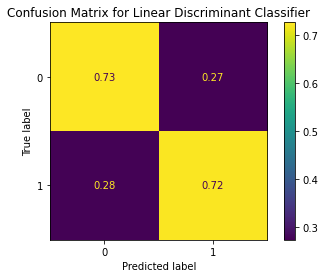

In [24]:
plot_confusion_matrix(lda,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for Linear Discriminant Classifier')
plt.show()

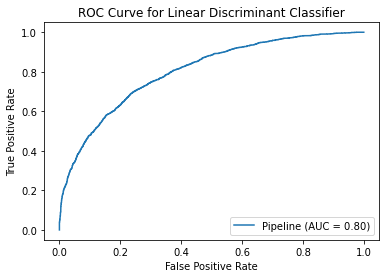

In [25]:
plot_roc_curve(lda,x_test,y_test)
plt.title('ROC Curve for Linear Discriminant Classifier')
plt.show()

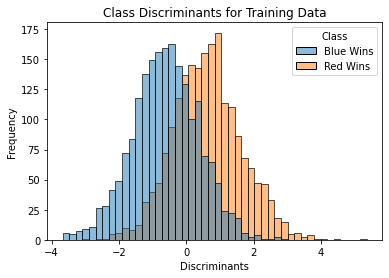

In [26]:
class_discrims = pd.DataFrame({
    'Discriminants' : lda.transform(x_train)[:,0],
    'Class' : y_train
})
class_discrims['Class'] = class_discrims['Class'].replace([0,1],['Red Wins', 'Blue Wins'])

sbn.histplot(data = class_discrims, x = 'Discriminants', hue = 'Class')
plt.ylabel('Frequency')
plt.title('Class Discriminants for Training Data')
plt.show()

In [27]:
pd.DataFrame(lda['LDA'].coef_.T)

,0
0,-0.589297
1,-0.056807
2,0.007134
3,0.035568
4,-0.013790
5,-0.055457
6,-0.060528
7,-0.002033
8,-0.084160
9,0.060401


Coefficients of linear discriminant.

In [55]:
lda['LDA'].priors_

array([0.50088585, 0.49911415])

Prior probabilities of class 0 and 1 respectively.

## Logistic Regression

In [28]:
#Optimising model in region about default values
params = {
    'LR__C' : [i/10 for i in range(0,11)]
}

clf = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('LR', LogisticRegression(random_state=82))
])

gd_sr = GridSearchCV(estimator=clf,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
clf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1506s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  33 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  33 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  22 out of  33 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  26 out of  33 | elapsed:    0.6s remaining:    0.1s
Optimal Paramaters: {'LR__C': 0.1}
[Parallel(n_jobs=-1)]: Done  30 out of  33 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.8s finished


In [29]:
print('Logistic Regression')

print('\n')
print('Logistic Regression Train Data Report')
print(classification_report(y_pred = clf.predict(x_train), y_true = y_train))

print('\n')
print('Logistic Regression Test Data Report')
print(classification_report(y_pred = clf.predict(x_test), y_true = y_test))

Logistic Regression


Logistic Regression Train Data Report
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1979
           1       0.74      0.74      0.74      1972

    accuracy                           0.74      3951
   macro avg       0.74      0.74      0.74      3951
weighted avg       0.74      0.74      0.74      3951



Logistic Regression Test Data Report
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2970
           1       0.72      0.72      0.72      2958

    accuracy                           0.73      5928
   macro avg       0.73      0.73      0.73      5928
weighted avg       0.73      0.73      0.73      5928



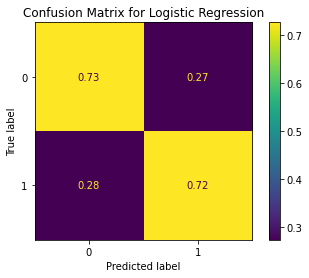

In [30]:
plot_confusion_matrix(clf,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

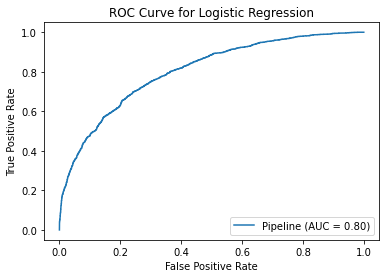

In [31]:
plot_roc_curve(clf,x_test,y_test)
plt.title('ROC Curve for Logistic Regression')
plt.show()

## Neural Network

In [32]:
#Optimising model in region about default values
params = {
    'NN__hidden_layer_sizes' : [(90,),(100,),(110,),(90,90),(100,100),(110,110),(90,90,90),(100,100,100),(110,110,110)]
}

cnn = Pipeline(steps=[
    ('Preprocessing', preprocessor),
    ('NN', MLPClassifier(random_state=29))
])

gd_sr = GridSearchCV(estimator=cnn,param_grid=params,cv=cv,n_jobs=-1, scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
cnn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   7 out of  27 | elapsed:    5.0s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:    9.2s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  13 out of  27 | elapsed:   16.0s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:   17.3s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  19 out of  27 | elapsed:   17.6s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:   20.2s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed:   23.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   23.9s finished
Optimal Paramaters: {'NN__hidden_layer_sizes': (110,)}


In [33]:
print('\n')
print('Neural Network Train Data Report')
print(classification_report(y_pred = cnn.predict(x_train), y_true = y_train))

print('\n')
print('Neural Network Test Data Report')
print(classification_report(y_pred = cnn.predict(x_test), y_true = y_test))



Neural Network Train Data Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1979
           1       0.81      0.85      0.83      1972

    accuracy                           0.83      3951
   macro avg       0.83      0.83      0.83      3951
weighted avg       0.83      0.83      0.83      3951



Neural Network Test Data Report
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      2970
           1       0.69      0.72      0.70      2958

    accuracy                           0.70      5928
   macro avg       0.70      0.70      0.70      5928
weighted avg       0.70      0.70      0.70      5928



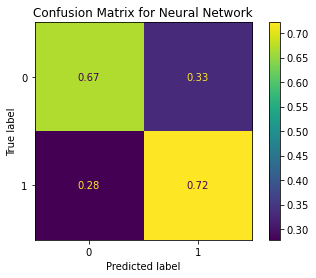

In [34]:
plot_confusion_matrix(cnn, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Neural Network')
plt.show()

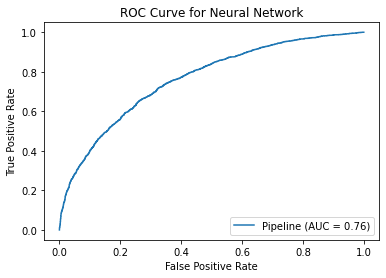

In [35]:
plot_roc_curve(cnn,x_test,y_test)
plt.title('ROC Curve for Neural Network')
plt.show()

## Random Forest

In [36]:
#Optimising model in region about default values
params = {
    'RF__n_estimators' : [i*10 for i in range(7,14)],
    'RF__min_samples_split' : [i for i in range(2,5)]
}

crf = Pipeline(steps=[
    ('Preprocessing', preprocessor),
    ('RF', RandomForestClassifier(random_state=32))
])

gd_sr = GridSearchCV(estimator=crf,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
crf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  47 out of  63 | elapsed:    5.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  54 out of  63 | elapsed:    6.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  61 out of  63 | elapsed:    7.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    7.5s finished
Optimal Paramaters: {'RF__min_samples_split': 2, 'RF__n_estimators': 70}


In [37]:
print('\n')
print('Random Forest Train Data Report')
print(classification_report(y_pred = crf.predict(x_train), y_true = y_train))

print('\n')
print('Random Forest Test Data Report')
print(classification_report(y_pred = crf.predict(x_test), y_true = y_test))



Random Forest Train Data Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1979
           1       1.00      1.00      1.00      1972

    accuracy                           1.00      3951
   macro avg       1.00      1.00      1.00      3951
weighted avg       1.00      1.00      1.00      3951



Random Forest Test Data Report
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2970
           1       0.71      0.71      0.71      2958

    accuracy                           0.71      5928
   macro avg       0.71      0.71      0.71      5928
weighted avg       0.71      0.71      0.71      5928



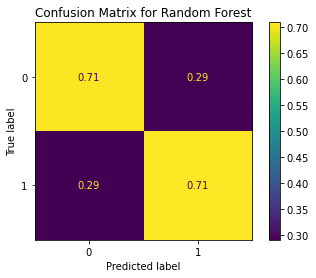

In [38]:
plot_confusion_matrix(crf, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Random Forest')
plt.show()

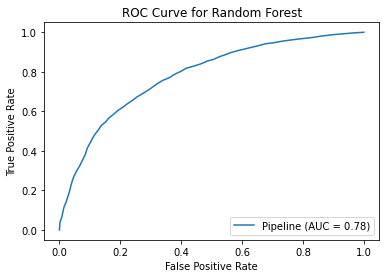

In [39]:
plot_roc_curve(crf,x_test,y_test)
plt.title('ROC Curve for Random Forest')
plt.show()

## AdaBoost

In [40]:
#Optimising model in region about default values
params = {
    'AD__n_estimators' : [i*10 for i in range(4,7)],
}

cad = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('AD', AdaBoostClassifier(random_state=32, base_estimator=LogisticRegression()))
])

gd_sr = GridSearchCV(estimator=cad,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
cad = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
Optimal Paramaters: {'AD__n_estimators': 50}


In [41]:
print('\n')
print('ADA Boost Train Data Report')
print(classification_report(y_pred = cad.predict(x_train), y_true = y_train))

print('\n')
print('ADA Boost Test Data Report')
print(classification_report(y_pred = cad.predict(x_test), y_true = y_test))



ADA Boost Train Data Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1979
           1       0.73      0.74      0.74      1972

    accuracy                           0.74      3951
   macro avg       0.74      0.74      0.74      3951
weighted avg       0.74      0.74      0.74      3951



ADA Boost Test Data Report
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      2970
           1       0.72      0.72      0.72      2958

    accuracy                           0.72      5928
   macro avg       0.72      0.72      0.72      5928
weighted avg       0.72      0.72      0.72      5928



## Voting Classifier

In [42]:
cvt = Pipeline(steps = [
    ('VC', VotingClassifier(estimators=[('ad', cad),('lf', clf),('lda', lda)], voting='hard'))
])
cvt = cvt.fit(x_train,y_train)

In [43]:
print('\n')
print('Voting Classifier Train Data Report')
print(classification_report(y_pred = cvt.predict(x_train), y_true = y_train))

print('\n')
print('Voting Classifier Test Data Report')
print(classification_report(y_pred = cvt.predict(x_test), y_true = y_test))



Voting Classifier Train Data Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1979
           1       0.73      0.74      0.74      1972

    accuracy                           0.74      3951
   macro avg       0.74      0.74      0.74      3951
weighted avg       0.74      0.74      0.74      3951



Voting Classifier Test Data Report
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2970
           1       0.72      0.72      0.72      2958

    accuracy                           0.73      5928
   macro avg       0.73      0.73      0.73      5928
weighted avg       0.73      0.73      0.73      5928



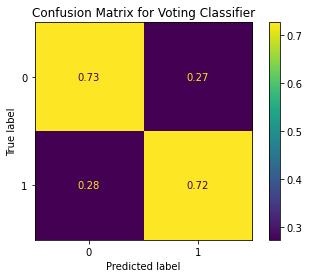

In [44]:
plot_confusion_matrix(cvt, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Voting Classifier')
plt.show()

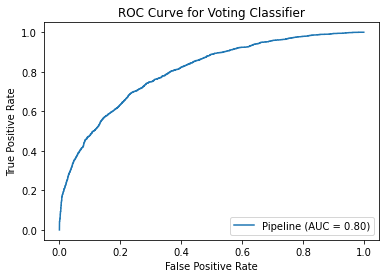

In [45]:
plot_roc_curve(cad,x_test,y_test)
plt.title('ROC Curve for Voting Classifier')
plt.show()

# Comparison of Model Performance on Cross Validation

In [46]:
cv = KFold(n_splits=10, random_state=40, shuffle=True)
accs = {'trial' : [i for i in range(1,11)]}
rs = {'trial' : [i for i in range(1,11)]}

In [47]:
accs['Voting Classifier - Accuracy'] = cross_val_score(estimator=cvt,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Voting Classifier - Macro Recall'] = cross_val_score(estimator=cvt,X=x_train,y=y_train,scoring=macro_recall,cv=cv,n_jobs=-1)

accs['AdaBoost - Accuracy'] = cross_val_score(estimator=cad,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['AdaBoost - Macro Recall'] = cross_val_score(estimator=cad,X=x_train,y=y_train,scoring=macro_recall, cv=cv, n_jobs=-1)

accs['Random Forest - Accuracy'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Random Forest - Macro Recall'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring=macro_recall, cv=cv, n_jobs=-1)

accs['Neural Network - Accuracy'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Neural Network - Macro Recall'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring=macro_recall,cv=cv, n_jobs=-1)

accs['Logistic Regression - Accuracy'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Logistic Regression - Macro Recall'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring=macro_recall,cv=cv, n_jobs=-1)

accs['Linear Discriminant Classifier - Accuracy'] = cross_val_score(estimator=lda,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
rs['Linear Discriminant Classifier - Macro Recall'] = cross_val_score(estimator=lda,X=x_train,y=y_train,scoring=macro_recall,cv=cv,n_jobs=-1)

accs = pd.DataFrame(accs)
rs = pd.DataFrame(rs)

In [48]:
accs

,trial,Voting Classifier - Accuracy,AdaBoost - Accuracy,Random Forest - Accuracy,Neural Network - Accuracy,Logistic Regression - Accuracy,Linear Discriminant Classifier - Accuracy
0,1,0.727273,0.719697,0.712121,0.686869,0.729798,0.724747
1,2,0.698734,0.701266,0.688608,0.673418,0.698734,0.693671
2,3,0.706329,0.708861,0.724051,0.678481,0.706329,0.703797
3,4,0.769620,0.767089,0.746835,0.729114,0.767089,0.759494
4,5,0.731646,0.724051,0.706329,0.721519,0.729114,0.724051
5,6,0.744304,0.749367,0.749367,0.744304,0.746835,0.744304
6,7,0.739241,0.741772,0.736709,0.746835,0.731646,0.741772
7,8,0.764557,0.764557,0.759494,0.736709,0.764557,0.767089
8,9,0.744304,0.749367,0.736709,0.686076,0.744304,0.746835
9,10,0.703797,0.706329,0.708861,0.688608,0.706329,0.698734


In [49]:
rs

,trial,Voting Classifier - Macro Recall,AdaBoost - Macro Recall,Random Forest - Macro Recall,Neural Network - Macro Recall,Logistic Regression - Macro Recall,Linear Discriminant Classifier - Macro Recall
0,1,0.728756,0.720981,0.713872,0.688510,0.731459,0.726720
1,2,0.699158,0.702021,0.689230,0.674231,0.699158,0.694085
2,3,0.704443,0.706539,0.720893,0.676352,0.704443,0.702346
3,4,0.768720,0.766060,0.745760,0.728608,0.766304,0.758814
4,5,0.731584,0.723648,0.706002,0.721221,0.728939,0.724084
5,6,0.742483,0.747550,0.748114,0.742765,0.744946,0.742483
6,7,0.738708,0.741159,0.735089,0.745393,0.731021,0.741325
7,8,0.764348,0.764438,0.759912,0.736806,0.764438,0.766836
8,9,0.744257,0.749321,0.736669,0.686048,0.744257,0.746783
9,10,0.703965,0.706625,0.709040,0.688496,0.706380,0.699134


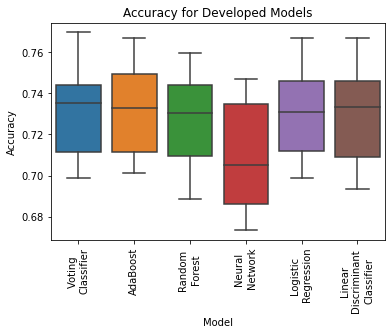

In [50]:
bplot = sbn.boxplot(data=accs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Voting \nClassifier', 'AdaBoost', 'Random \nForest','Neural \nNetwork','Logistic \nRegression','Linear \nDiscriminant \nClassifier'],rotation=90)
plt.title('Accuracy for Developed Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

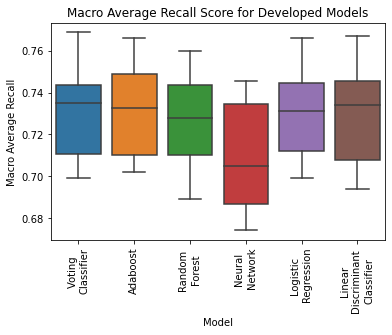

In [51]:
bplot = sbn.boxplot(data=rs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Voting \nClassifier', 'Adaboost', 'Random \nForest','Neural \nNetwork','Logistic \nRegression','Linear \nDiscriminant \nClassifier'],rotation=90)
plt.title('Macro Average Recall Score for Developed Models')
plt.xlabel('Model')
plt.ylabel('Macro Average Recall')
plt.show()